In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

C:\Users\Blessy Thomas\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
company_data = yf.download('RELIANCE.NS', period='5y', interval ="1wk")
data_df = pd.DataFrame(company_data['Close'])
data_df

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2019-08-12,1168.517212
2019-08-19,1166.551392
2019-08-26,1141.590088
2019-09-02,1117.771729
2019-09-09,1120.606201
...,...
2024-07-15,3110.300049
2024-07-22,3018.050049
2024-07-29,2998.649902


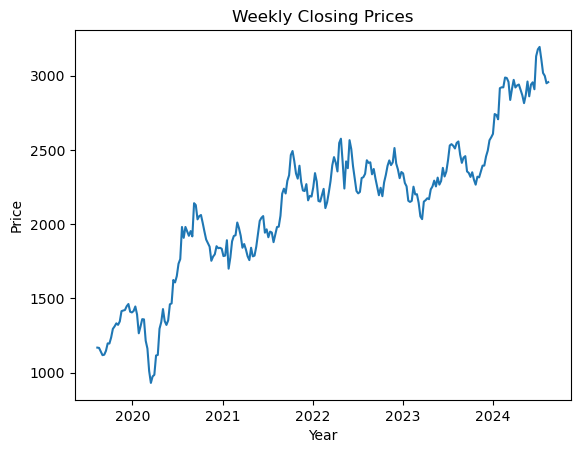

In [3]:

# Plot the weekly closing prices
plt.plot(data_df['Close'])
plt.title('Weekly Closing Prices')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()


In [30]:
# Calculate the logarithmic weekly returns
data_df['Ln_Return'] = np.log(data_df['Close'] / data_df['Close'].shift(1))
data_df = data_df.dropna() #null value treatment
print(data_df)



                  Close  Ln_Return
Date                              
2019-08-26  1141.590088  -0.021630
2019-09-02  1117.771729  -0.021085
2019-09-09  1120.606201   0.002533
2019-09-16  1146.893188   0.023187
2019-09-23  1196.907227   0.042684
...                 ...        ...
2024-07-15  3110.300049  -0.026383
2024-07-22  3018.050049  -0.030108
2024-07-29  2998.649902  -0.006449
2024-08-05  2948.600098  -0.016832
2024-08-12  2956.399902   0.002642

[260 rows x 2 columns]


C:\Users\Blessy Thomas\AppData\Local\Temp\ipykernel_15240\2168563041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['Ln_Return'] = np.log(data_df['Close'] / data_df['Close'].shift(1))


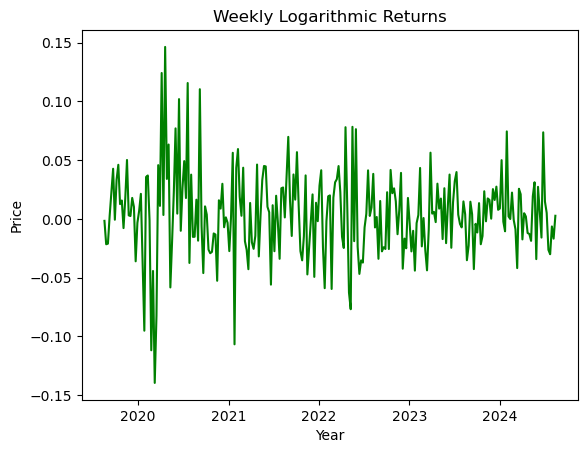

In [5]:
# Plot the weekly returns 
plt.plot(data_df['Ln_Return'], color="green")
plt.title('Weekly Logarithmic Returns')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

### Checking for Null Values

In [6]:
data_df.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2019-08-19 to 2024-08-12
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Close      261 non-null    float64
 1   Ln_Return  261 non-null    float64
dtypes: float64(2)
memory usage: 6.1 KB


## Checking stationarity of the level data (ln_return) using Augmented Dicky Fuller Test
#### They can only be used to inform the degree to which a null hypothesis can be rejected or fail to be reject

### H0: The data is not stationary
### H1: Data is stationary


In [7]:
X = data_df["Ln_Return"].dropna()
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Log returns are Stationary")
else:
    print ("Failed to Reject Ho - Log returns are Non-Stationary")

ADF Statistic: -14.982114
p-value: 0.000000
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573
Reject Ho - Log returns are Stationary


### Checking for autocorrelation & partial autocorrelation

C:\Users\Blessy Thomas\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


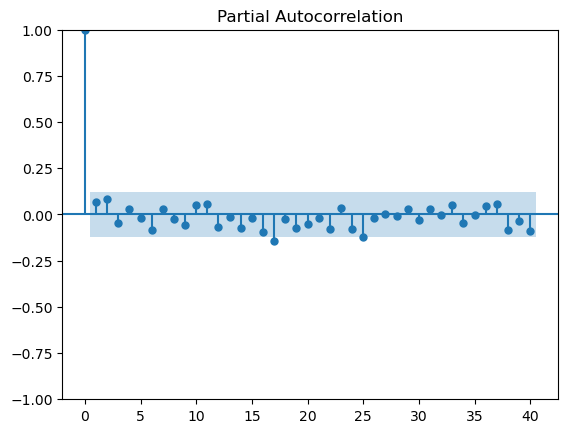

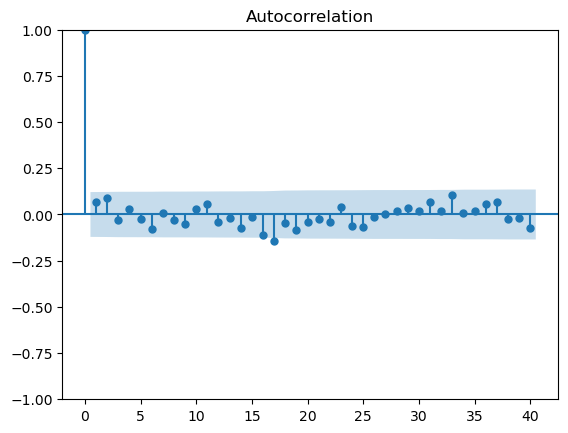

In [8]:
pacf = plot_pacf(data_df['Ln_Return'], lags = 40)
acf = plot_acf(data_df['Ln_Return'], lags = 40)

#### PACF shows the dependent variable's correlation with its lags, graph shows there isn't much correlation with the lags. Since we want to see the final effect we'll move forward with lag 1 as independent variable for our model. 

## Fitting the Autogressive model 

In [86]:
#Splitting the data into training and testing part, prediction will be tested on 30% of the data
seventy_pct = int(0.7 * len(data_df))

train = data_df['Ln_Return'].iloc[:seventy_pct]
test = data_df['Ln_Return'].iloc[seventy_pct::]

In [87]:
#first trying the model with lag 1 
model = AutoReg(train,lags=1).fit()

C:\Users\Blessy Thomas\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


In [88]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              Ln_Return   No. Observations:                  182
Model:                     AutoReg(1)   Log Likelihood                 321.715
Method:               Conditional MLE   S.D. of innovations              0.041
Date:                Sun, 18 Aug 2024   AIC                           -637.431
Time:                        14:59:12   BIC                           -627.835
Sample:                    09-02-2019   HQIC                          -633.540
                         - 02-13-2023                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0035      0.003      1.138      0.255      -0.003       0.009
Ln_Return.L1     0.0833      0.074      1.122      0.262      -0.062       0.229
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           12.0102           +0.0000j           12.0102            0.0000
-----------------------------------------------------------------------------
"""

### p-value for most of the lags is greater than 0.05 indicating there is no significant impact in predicting the future prices. However, lag 8 has p value less than 0.05, hence it is  significant.

In [91]:
#Predicting the values for the last 30% of the dates 

predict = model.predict(start = len(train), end = len(data_df)-1, dynamic =False)
print(predict)

2023-02-20    0.007082
2023-02-27    0.004061
2023-03-06    0.003810
2023-03-13    0.003789
2023-03-20    0.003787
                ...   
2024-07-15    0.003787
2024-07-22    0.003787
2024-07-29    0.003787
2024-08-05    0.003787
2024-08-12    0.003787
Freq: W-MON, Length: 78, dtype: float64


C:\Users\Blessy Thomas\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


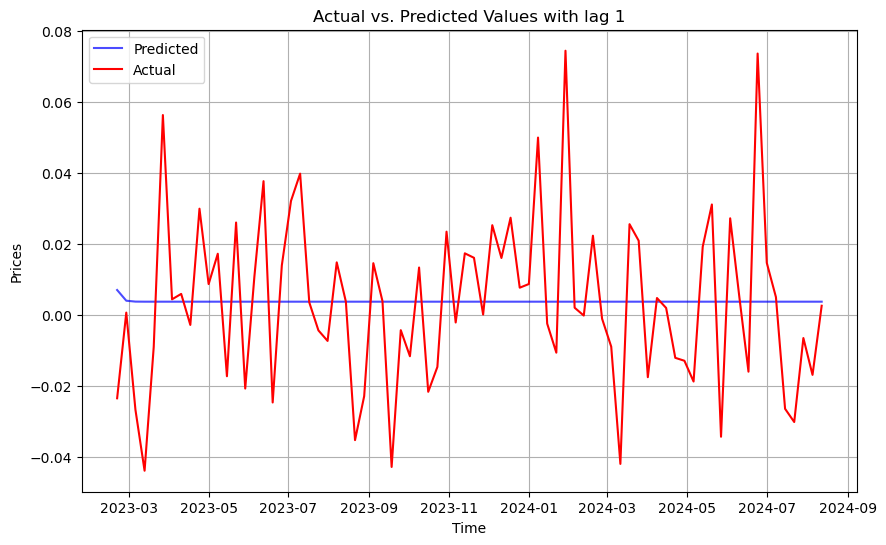

In [92]:
# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(predict, color='blue', label='Predicted', alpha=0.7)
plt.plot(test, color='red', label='Actual')
plt.title('Actual vs. Predicted Values with lag 1')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.legend()
plt.grid()
plt.show()

#### Plot clearly shows the predicted values are close to the actual value in the initial stage however later on they fail to predict, this is because most of the lags didn't have a significant impact in predicting the stock prices

## Checking for Endogenity

In [94]:
predict_data =data_df.iloc[seventy_pct:]
predict_data['Predicted']=predict
predict_data['Residuals'] = predict_data['Ln_Return'] - predict_data['Predicted']
predict_data

C:\Users\Blessy Thomas\AppData\Local\Temp\ipykernel_15240\1920173190.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['Predicted']=predict
C:\Users\Blessy Thomas\AppData\Local\Temp\ipykernel_15240\1920173190.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['Residuals'] = predict_data['Ln_Return'] - predict_data['Predicted']


,Close,Ln_Return,Residuals,Predicted
Date,,,,
2023-02-20,2200.154297,-0.023426,-0.030508,0.007082
2023-02-27,2201.723389,0.000713,-0.003348,0.004061
2023-03-06,2143.851318,-0.026637,-0.030446,0.003810
2023-03-13,2051.920654,-0.043828,-0.047616,0.003789
2023-03-20,2033.645142,-0.008946,-0.012734,0.003787
...,...,...,...,...
2024-07-15,3110.300049,-0.026383,-0.030170,0.003787
2024-07-22,3018.050049,-0.030108,-0.033895,0.003787
2024-07-29,2998.649902,-0.006449,-0.010236,0.003787


In [69]:
# Check correlation between residuals and independent variables
correlation_with_lag1 = data_df['Residuals'].corr(data_df['Ln_Return'].shift(1))
#correlation_with_lag2 = data_df['residuals'].corr(data_df['lag_2_return'])

print(f"Correlation between residuals and lag_1_return: {correlation_with_lag1}")
#print(f"Correlation between residuals and lag_2_return: {correlation_with_lag2}")

Correlation between residuals and lag_1_return: -0.00041282419926988586


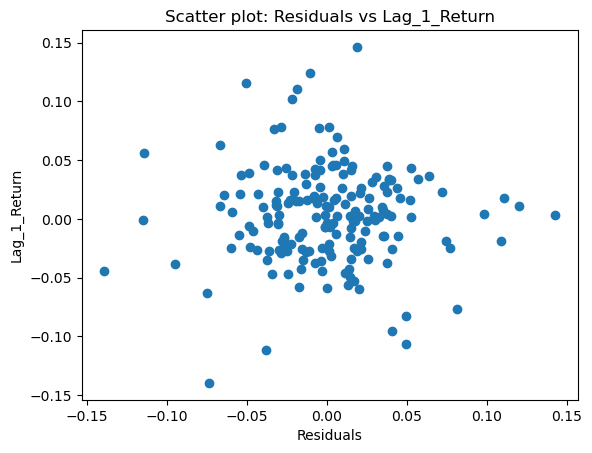

In [70]:
plt.scatter(data_df['Residuals'], data_df['Ln_Return'].shift(1))
plt.xlabel('Residuals')
plt.ylabel('Lag_1_Return')
plt.title('Scatter plot: Residuals vs Lag_1_Return')
plt.show()

### The spread of data shows that there is almost no correlation between the independent lag variable and the residual, indicating no presence of endogeneity. For deeper introspection to check for formal endogeneity we can use other methods.